In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Union

import candle
import candle.functions as F
import experiments.trainingutils as tutils

## (0) Contents

* [(1) Load data](#(1)-Load-data)
* [(2) Define Training Config](#(2)-Define-Training-Config)
* [(3) Define Model, Optimizer, and Scheduler](#(3)-Define-Model,-Optimizer,-and-Scheduler)
* [(4) Profile Activations and Gradients at Initialization](#(4)-Profile-Activations-and-Gradients-at-Initialization)
* [(5) Train Model](#(5)-Train-Model)
* [(6) Visualize Predictions](#(6)-Visualize-Predictions)
* [(7) Visualize Kernel](#(7)-Visualize-Kernel)

## (1) Load data

In [3]:
import torchvision

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

X_train = candle.Tensor(np.moveaxis(cifar_train.data, 3, 1).astype(float))  # (N, channels, height, width)
y_train = candle.Tensor(np.array(cifar_train.targets))
X_test = candle.Tensor(np.moveaxis(cifar_test.data, 3, 1).astype(float))
y_test = candle.Tensor(np.array(cifar_test.targets))

num_classes = len(set(y_train.data))

print('X_train.shape, targets_train.shape:', X_train.shape, y_train.shape)
print('X_test.shape,  targets_test.shape: ', X_test.shape, y_test.shape)
print('num_classes:', num_classes)

Files already downloaded and verified
Files already downloaded and verified
X_train.shape, targets_train.shape: (50000, 3, 32, 32) (50000,)
X_test.shape,  targets_test.shape:  (10000, 3, 32, 32) (10000,)
num_classes: 10


## (2) Define Training Config

In [4]:
class Config:
    # Optimization configs
    
    ITERATIONS = 81000  # Roughly 200 epochs
    BATCH_SIZE = 128
    LEARNING_RATE = 0.1
    WEIGHT_DECAY = 1e-4
    SGD_MOMENTUM = 0.9
    
    EVAL_ITERS = 4
    EVAL_BATCH_SIZE = 64
    DASHBOARD_REFRESH_ITERS = 200
    
    # LR scheduler configs
    
    MULTISTEPLR_MILESTONES = [40000, 60000]  # Roughly 100 and 150 epochs
    MULTISTEPLR_GAMMA = 0.1
    WARMUP_STEPS = 1000  # 2 epochs of warmup
    
    # Model architecture configs

    RESNET_BLOCKS = [
        # (in_channels, out_channels, stride)
        (16, 16, 1),
        (16, 16, 1),
        (16, 16, 1),

        (16, 32, 2),
        (32, 32, 1),
        (32, 32, 1),

        (32, 64, 2),
        (64, 64, 1),
        (64, 64, 1),
    ]


config = Config()

## (3) Define Model, Optimizer, and Scheduler

In [5]:
model = candle.models.resnet.ResNet(num_classes=num_classes,
                                    in_channels=X_train.shape[1],
                                    resnet_blocks=config.RESNET_BLOCKS)

optimizer = candle.optimizer.SGD(model.parameters(),
                                 momentum=config.SGD_MOMENTUM,
                                 learning_rate=config.LEARNING_RATE,
                                 weight_decay=config.WEIGHT_DECAY)

scheduler = candle.scheduler.WarmupWrapper(candle.scheduler.MultiStepLR(optimizer,
                                                                        milestones=config.MULTISTEPLR_MILESTONES,
                                                                        gamma=config.MULTISTEPLR_GAMMA),
                                           warmup_steps=config.WARMUP_STEPS)

model.summary(input_shape=(64, 3, 32, 32))

Layer Type # Parameters      Output Shape
                                                             
batch_norm           BatchNorm           32  (64, 16, 32, 32)
conv                    Conv2d          448  (64, 16, 32, 32)
linear                  Linear          650          (64, 10)
max_pool             MaxPool2d            0              None
residual_blocks 0  ResNetBlock         4704  (64, 16, 32, 32)
                1  ResNetBlock         4704  (64, 16, 32, 32)
                2  ResNetBlock         4704  (64, 16, 32, 32)
                3  ResNetBlock        14560  (64, 32, 16, 16)
                4  ResNetBlock        18624  (64, 32, 16, 16)
                5  ResNetBlock        18624  (64, 32, 16, 16)
                6  ResNetBlock        57792    (64, 64, 8, 8)
                7  ResNetBlock        74112    (64, 64, 8, 8)
                8  ResNetBlock        74112    (64, 64, 8, 8)
Total                                273066

## (4) Profile Activations and Gradients at Initialization

In [6]:
# Register forward hooks to facilitate activation logging

layer_activations = {}
def store_activations(layer_name):
    def hook_fn(module, input, output):
        layer_activations[layer_name] = output
    
    return hook_fn


def get_activations():
    act_by_layer = {layer_name: layer_activations[layer_name].data.flatten() for layer_name in layer_activations}
    activations = np.concatenate(list(act_by_layer.values()))
    act_norm_by_layer = {layer_name: np.linalg.norm(act) for (layer_name, act) in act_by_layer.items()}
    act_rmsnorm_by_layer = {name: np.sqrt(np.mean(np.square(act_by_layer[name]))) for name in act_by_layer}
    
    return (activations, act_by_layer, act_norm_by_layer, act_rmsnorm_by_layer)


params_to_track = (
    [f'residual_blocks.{i}.conv1.kernel' for i in range(len(model.residual_blocks))]
    + [f'residual_blocks.{i}.conv2.kernel' for i in range(len(model.residual_blocks))]
)

for (i, layer) in enumerate(model.residual_blocks):
    layer.register_forward_hook(store_activations(f'residual_blocks.{i}'))    

In [7]:
# Feed batch in to get activations

X_batch = X_train[:256]
y_batch = y_train[:256]

output = model(X_batch)
loss = F.cross_entropy_loss(output, y_batch)
loss.backward()

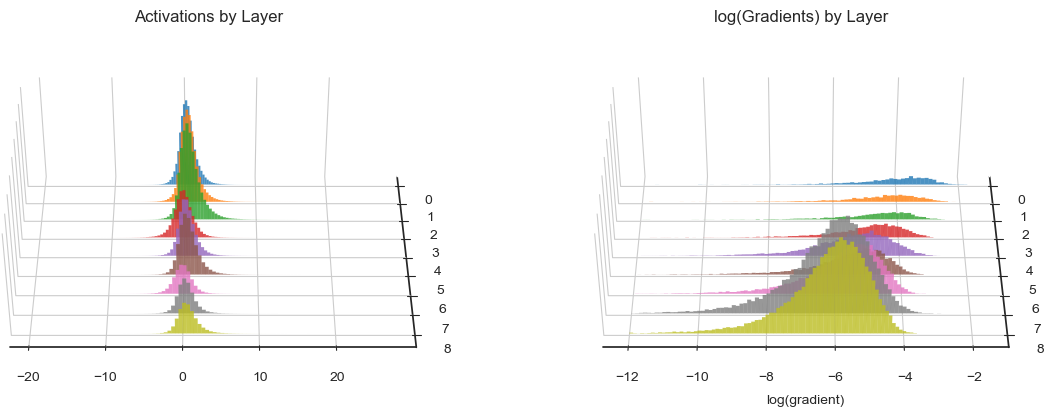

In [8]:
# Plot activations and gradients at init

writer = candle.Dashboard()
writer.change_settings('xlim', (-12, np.inf), chart_label='log(Gradients) by Layer')
writer.change_settings('hist_xlabel', 'log(gradient)', chart_label='log(Gradients) by Layer')

for layer_name in layer_activations:
    writer.add_histogram('Activations by Layer', layer_activations[layer_name].data.flatten())

for layer in model.residual_blocks:
    gradients = layer.conv1.kernel.grad.flatten()
    writer.add_histogram('log(Gradients) by Layer', np.log(np.abs(gradients) + 1e-10))

writer.plot()

## (5) Train Model

In [9]:
# Initialize dashboard

writer = candle.Dashboard()
for label in ['Parameter', 'Gradient', 'Update', 'Adam Variance']:
    writer.change_settings('xlim', (-20, np.inf), chart_label=f'log({label})')
    writer.change_settings('yscale', 'log', chart_label=f'{label} Norm by Layer')

In [10]:
# Create data augmentations transforms

train_transforms = candle.vision.Compose([
    candle.vision.RandomCrop(32, padding=4),
    candle.vision.RandomHorizontalFlip(),
    candle.vision.Normalize((120, 120, 120), (63, 63, 63))
])
test_transforms = candle.vision.Compose([
    candle.vision.Normalize((120, 120, 120), (63, 63, 63))
])

data_loader = candle.DataLoader(X_train, y_train, batch_size=config.BATCH_SIZE,
                                shuffle=True, drop_last=True, transforms=[train_transforms, None])
data_iterator = iter(data_loader)

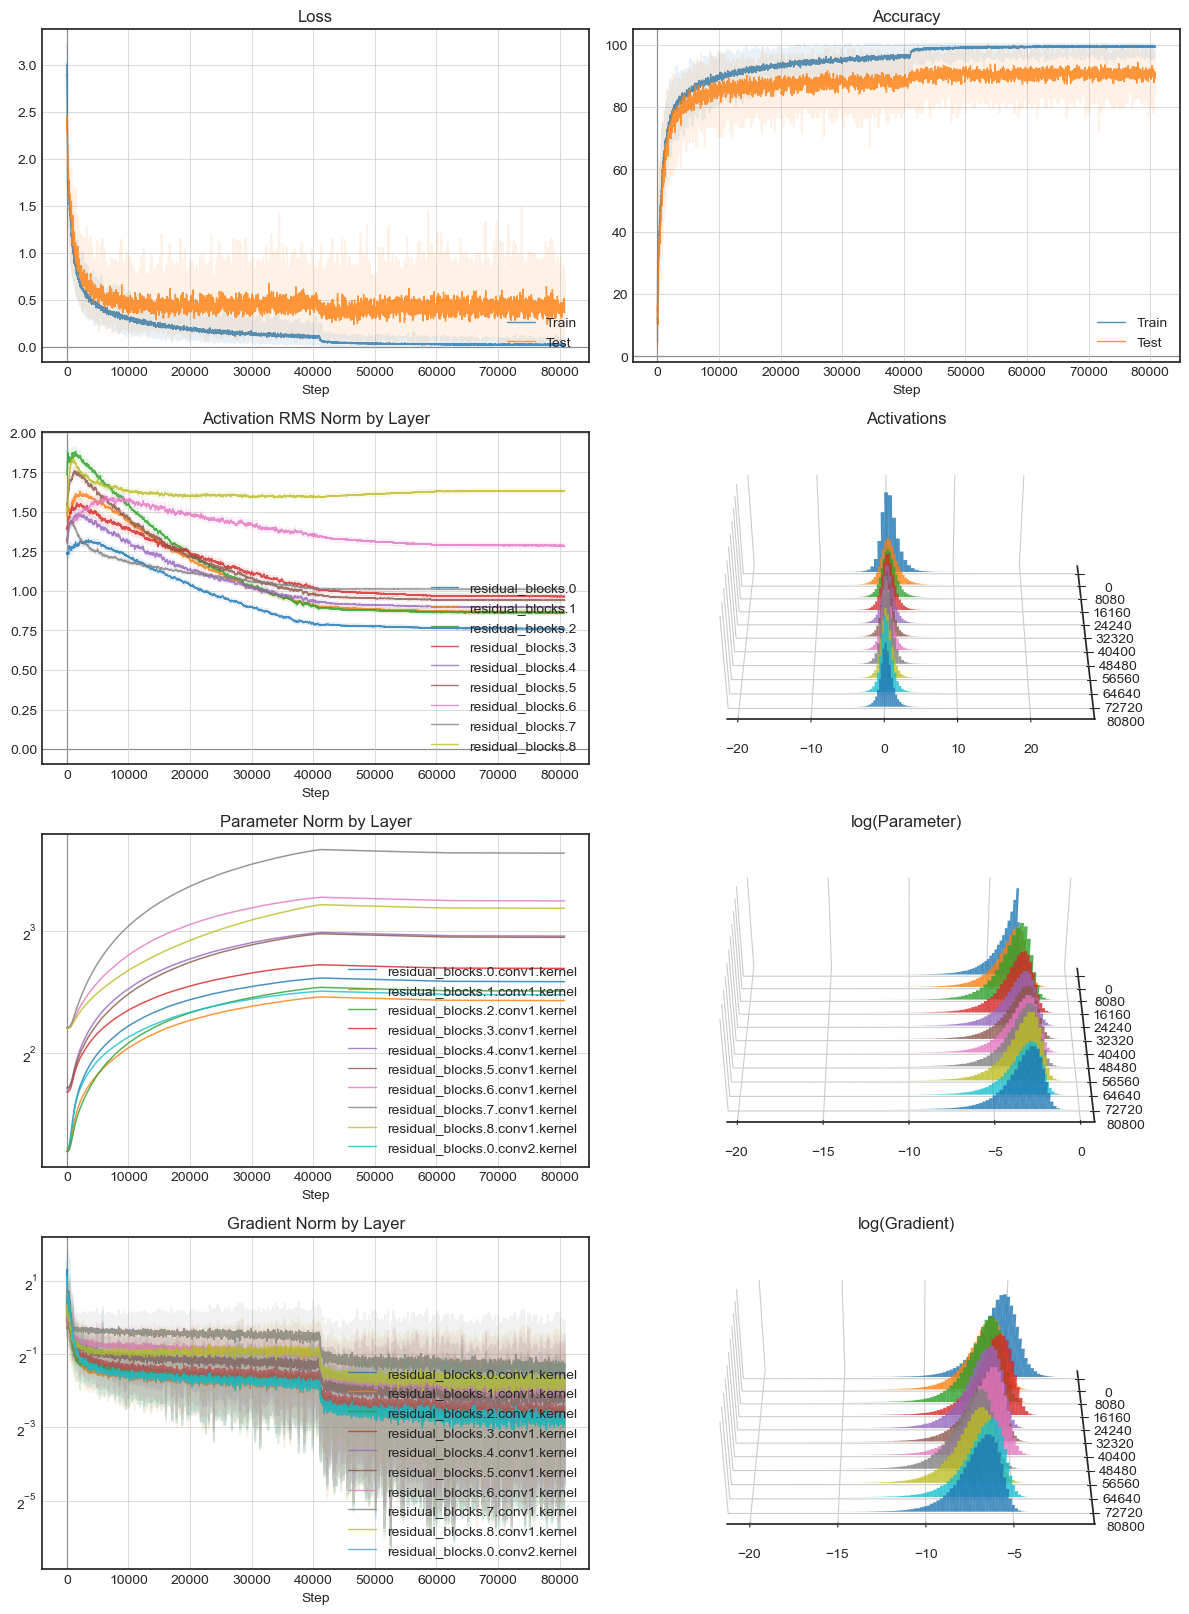

In [11]:
for iteration in range(config.ITERATIONS):
    
    model.train()

    try:
        (X_batch, y_batch) = next(data_iterator)
    except StopIteration:
        data_iterator = iter(data_loader)
        (X_batch, y_batch) = next(data_iterator)

    optimizer.zero_grad()
    output = model(X_batch)
    loss = F.cross_entropy_loss(output, y_batch)
    loss.backward()
    
    optimizer.step()
    scheduler.step()

    # ----------------
    # Update dashboard
    # ----------------

    model.eval()
    
    (activations, act_by_layer, act_norm_by_layer, act_rmsnorm_by_layer) = get_activations()
    (parameters, param_by_layer, param_norm_by_layer) = tutils.get_parameters(params_to_track, model)
    (gradients, grad_by_layer, grad_norm_by_layer) = tutils.get_gradients(params_to_track, model)
    
    (train_loss, train_acc) = tutils.get_loss_and_accuracy(model, X_batch, y_batch, output.data)
    writer.add_scalars('Loss', {'Train': train_loss})
    writer.add_scalars('Accuracy', {'Train': train_acc})

    if iteration % config.EVAL_ITERS == 0:
        test_batch = tutils.get_random_batch(X_test, y_test,
                                             batch_size=config.EVAL_BATCH_SIZE,
                                             transforms=[test_transforms, None])
        (test_loss, test_acc) = tutils.get_loss_and_accuracy(model, *test_batch)
        writer.add_scalars('Loss', {'Test': test_loss}, iteration)
        writer.add_scalars('Accuracy', {'Test': test_acc}, iteration)
    
    writer.add_scalars('Activation RMS Norm by Layer', act_rmsnorm_by_layer)
    writer.add_histogram('Activations', activations)
    
    writer.add_scalars('Parameter Norm by Layer', param_norm_by_layer)
    writer.add_histogram('log(Parameter)', np.log(np.abs(parameters) + 1e-10))
    
    writer.add_scalars('Gradient Norm by Layer', grad_norm_by_layer)
    writer.add_histogram('log(Gradient)', np.log(np.abs(gradients) + 1e-10))
        
    if iteration % config.DASHBOARD_REFRESH_ITERS == 0:
        writer.plot(clear_output=True)

## (6) Visualize Predictions

Final Test Accuracy: 90.54%


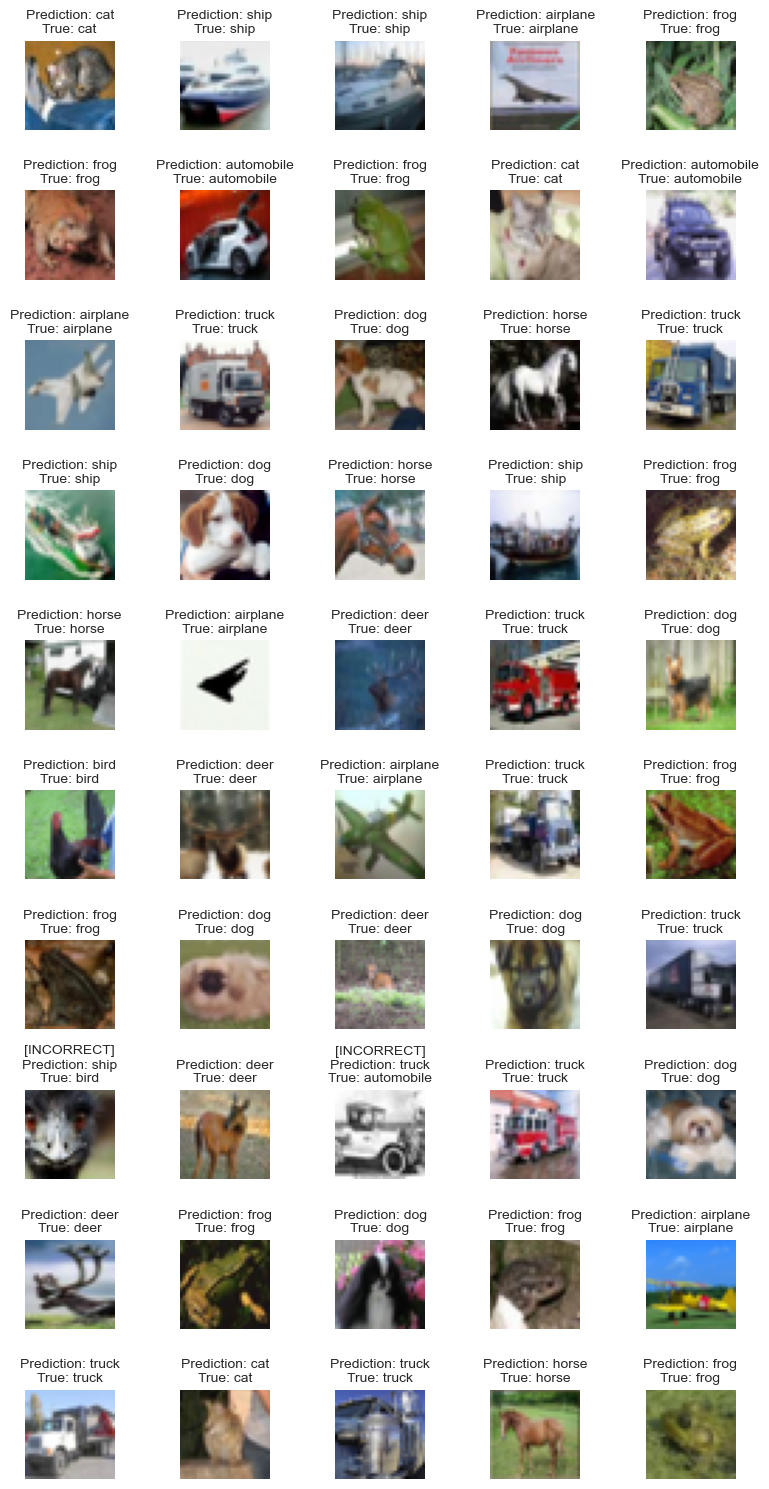

In [20]:
predictions = tutils.get_predictions(model, test_transforms(X_test))
(test_loss, test_acc) = tutils.get_loss_and_accuracy(model, test_transforms(X_test), y_test)
print(f'Final Test Accuracy: {test_acc:.2f}%')

(fig, axes) = plt.subplots(nrows=10, ncols=5, figsize=(8, 3*5))
axes = axes.flatten()
for (ax, image, prediction, label) in zip(axes, X_test.data, predictions, y_test.data):
    ax.set_axis_off()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]).astype(int)
    ax.imshow(image)
    (prediction, label) = cifar_train.classes[int(prediction)], cifar_train.classes[int(label)]
    wrong_label = '[INCORRECT]\n' if prediction != label else ''
    ax.set_title(f'{wrong_label}Prediction: {prediction}\nTrue: {label}', fontsize=10)
    
plt.tight_layout()
plt.show()

## (7) Visualize First Kernel

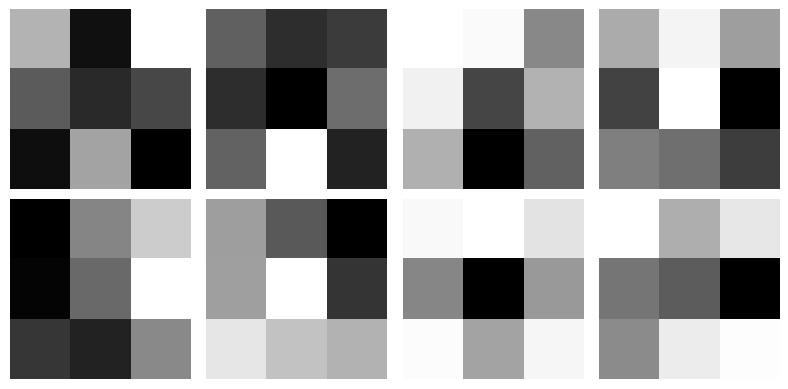

In [19]:
(fig, axes) = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
axes = axes.flatten()

in_channels = model.conv.kernel.shape[0]
out_channels = model.conv.kernel.shape[1]

in_channel_i = 0
for (ax, out_channel_i) in zip(axes, range(out_channels)):
    ax.set_axis_off()
    ax.imshow(model.conv.kernel[in_channel_i, out_channel_i].data, cmap=plt.cm.gray_r, interpolation='nearest')
    
plt.tight_layout()
plt.show()